# HF Bert Benchmark with Custom Modules
In this benchmark, we benchmark the effectiveness of PyTorch custom modules using HuggingFace Bert-large model on a NVIDIA V100 GPU.

## Setup

In [1]:
from IPython.display import clear_output
import os
import torch

!pip install datasets evaluate accelerate deepspeed psutil pybind11 huggingface_hub

clear_output()

print('Pytorch version\t:', torch.__version__)
print('PyTorch CUDA version\t:', torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t\t:',torch.cuda.get_device_name(i))

Pytorch version	: 1.12.1+cu116
PyTorch CUDA version	: 11.6
GPU0		: Tesla V100-SXM2-16GB
GPU1		: Tesla V100-SXM2-16GB
GPU2		: Tesla V100-SXM2-16GB
GPU3		: Tesla V100-SXM2-16GB
GPU4		: Tesla V100-SXM2-16GB
GPU5		: Tesla V100-SXM2-16GB
GPU6		: Tesla V100-SXM2-16GB
GPU7		: Tesla V100-SXM2-16GB


We then setup the required package (e.g., apex). Note that your CUDA environment (e.g., CUDA version) must align to the one your PyTorch built.

In [2]:
try:
    import apex
except ImportError:
    print("Installing apex")
    !git clone https://github.com/NVIDIA/apex.git || true
    clear_output()

    !cd apex; pip3 install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Next we steup HuggingFace transformers. We clone the repo and do the following:
1. Pin to a particular commit hash to make sure the results are reproducible.
2. Apply a patch to add some benchmark utilities.

In [3]:
!git clone https://github.com/huggingface/transformers || true
!cd transformers; git reset origin/main --hard; git checkout 12ce2941c7b67c0dedac0f0468b3ed854fa940ab
clear_output()

# Note that this patch is generated with transformers commit
# 801ebd045d4310fef2e837713fa630cb183f0104 @ Mon Sep 19 16:55:50 2022 -0400
with open("transformers/benchmark.patch", "w") as f:
    f.write('''
diff --git a/src/transformers/trainer.py b/src/transformers/trainer.py
index c1869ef76..06d33d24b 100755
--- a/src/transformers/trainer.py
+++ b/src/transformers/trainer.py
@@ -1712,7 +1712,9 @@ class Trainer:
                 self._load_rng_state(resume_from_checkpoint)

             step = -1
+            step_metrics = {"step_time_list": []}
             for step, inputs in enumerate(epoch_iterator):
+                step_start = time.time()

                 # Skip past any already trained steps if resuming training
                 if steps_trained_in_current_epoch > 0:
@@ -1819,6 +1821,7 @@ class Trainer:
                 else:
                     self.control = self.callback_handler.on_substep_end(args, self.state, self.control)

+                step_metrics["step_time_list"].append(time.time() - step_start)
                 if self.control.should_epoch_stop or self.control.should_training_stop:
                     break
             if step < 0:
@@ -1865,6 +1868,7 @@ class Trainer:
         train_loss = self._total_loss_scalar / self.state.global_step

         metrics = speed_metrics("train", start_time, num_samples=num_train_samples, num_steps=self.state.max_steps)
+        metrics.update(step_metrics)
         self.store_flos()
         metrics["total_flos"] = self.state.total_flos
         metrics["train_loss"] = train_loss
diff --git a/src/transformers/trainer_pt_utils.py b/src/transformers/trainer_pt_utils.py
index 7ff0eb51a..ea5134e5a 100644
--- a/src/transformers/trainer_pt_utils.py
+++ b/src/transformers/trainer_pt_utils.py
@@ -867,6 +867,8 @@ def metrics_format(self, metrics: Dict[str, float]) -> Dict[str, float]:
             metrics_copy[k] = f"{ int(v) >> 30 }GF"
         elif type(metrics_copy[k]) == float:
             metrics_copy[k] = round(v, 4)
+        elif "_list" in k:
+            metrics_copy[k] = f"{','.join(str(round(e, 4)) for e in v)}"

     return metrics_copy

''')

!cd transformers; git apply benchmark.patch; rm benchmark.patch; git status

# Install the changed transformers without checking dependencies (otherwise it may ruin your PyTorch setting...)
!cd transformers; pip install -e ".[dev]" --no-deps

HEAD detached from 801ebd045
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/transformers/trainer.py
	modified:   src/transformers/trainer_pt_utils.py

no changes added to commit (use "git add" and/or "git commit -a")
Obtaining file:///home/ubuntu/workspace_hf/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for transformers (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.24.0.dev0-0.editable-py3-none-any.whl size=30295 sha256=0deb335f736c2c4fcab26127298144d6e03714d4d324f1600f4d0d5c5e23fef6
  Stored in directory: /tmp/pip-ephem-wheel-cache-9q08k3rw/wheels/06/47/78/9d336557c3fcca46594a77391d65d1a7bb301749de7073f7ca
Successfully buil

In [4]:
# Whether to dump all plotted figures to PDF files.
dump_fig_to_pdf = False

## Benchmark Scripts
We then implement some utilities for benchmarking

In [5]:
import os
import re
import json

import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from transformers import AutoConfig, PretrainedConfig

@dataclass
class Exp:
    name: str           # Experiment name
    model: str          # huggingface model name
    batch_size: int     # batch size per GPU
    seq_len: int = None # input sequence length
        
    ## Improve speed / reduce memory  
    bf16: bool = False  # Faster, less memory. Recommend if GPU supports
    fp16: bool = False  # Faster, less memory, but need to scale loos. 
                        # Recommend if BF16 is not available.
    optim: str = 'adamw_hf'  # Optimization method
    grad_ckpt: bool = False  # save memory with an extra forward
    grad_accum: int = 1      # accumulate gradients for better performance
    steps: int = 20          # number of parameter updates
        
    ## Multi-GPUs
    gpus: str = '0'          # GPUs to use. "0,1" means use GPU 0 and 1
    tensor_para: int = 1     # Tensor parallelism
    deepspeed: bool = False  # if or not use deepspeed
    ds_config: str = ''      # deepspeed config
        
    ## kwargs
    kwargs: dict = None
        
    def __post_init__(self):         
        model_conf = AutoConfig.from_pretrained(self.model)
        get = lambda *keys: max([getattr(model_conf, k) if hasattr(model_conf, k) else 0 for k in keys])
        self.num_layers = get('num_hidden_layers', 'n_layer')
        self.num_gpus = len(self.gpus.split(','))                      
        self.hidden_size = get('hidden_size', 'n_embd', 'd_model')
        self.vocab_size = get('vocab_size')
        self.num_heads = get('num_attention_heads', 'n_head')
        if self.seq_len is None:
            self.seq_len = get('max_position_embeddings', 'n_ctx')
        n, h, s, v = self.num_layers, self.hidden_size, self.seq_len, self.vocab_size
        att, ffn, embed = 4*h*s**2 + 8*s*h**2, 16*s*h**2, 2*s*h*v
        forward = n*(att+ffn) + embed
        # TFLOPs to train one example
        self.tflops = (4 * forward if self.grad_ckpt else 3 * forward) / 1e12
        if self.deepspeed:            
            self.launcher = 'deepspeed'            
        else:
            self.launcher = f'torchrun --nproc_per_node {self.num_gpus}' 
            
    def print_results(self):
        print('Total samples / second\t: %.1f' % self.samples_per_sec)
        print('Per GPU memory (GB)\t: %.1f'% self.gpu_mem)
        print('Per GPU TFLOPs\t\t: %.1f' % (self.samples_per_sec * self.tflops / self.num_gpus))

In [6]:
%config InlineBackend.figure_formats = ['svg']

def compare(exps, save_to=""):
    fig, ax = plt.subplots(ncols=3, figsize=(9,len(exps)/2))
    x = list(range(len(exps)))
    for i, (y, l) in enumerate((
        ([e.samples_per_sec for e in exps], 'Samples / sec'), 
        ([e.samples_per_sec * e.tflops / e.num_gpus for e in exps], 'per GPU TFLOPS'),
        ([e.gpu_mem for e in exps], 'per GPU memory (GB)'))):
        print(f"{l}: {['%.2f' % e for e in y]}")
        ax[i].barh(x, y, align='center', height=0.6, color=plt.get_cmap('Set1')(x))
        ax[i].invert_yaxis()
        ax[i].set_xlabel(l)
        if i == 0:
            ax[i].set_yticks(x, labels=[e.name for e in exps])
        else:
            ax[i].set_yticklabels([])

    if save_to:
        plt.savefig(save_to, bbox_inches="tight")
    else:
        plt.show()

In [7]:
def hf_bert(exp):
    cmd = f'''export CUDA_VISIBLE_DEVICES={exp.gpus}; \
{exp.launcher} transformers/examples/pytorch/language-modeling/run_mlm.py \
--config_name {exp.model} --tokenizer_name {exp.model} \
--dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 \
--do_train --max_seq_length {exp.seq_len} \
--per_device_train_batch_size {exp.batch_size} \
--fp16 {exp.fp16} --bf16 {exp.bf16} \
--optim {exp.optim} --max_steps {exp.steps} \
--gradient_accumulation_steps {exp.grad_accum} \
--gradient_checkpointing {exp.grad_ckpt} \
--output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False'''
    if exp.deepspeed:
        cmd += f' --deepspeed {exp.ds_config}'
    if exp.kwargs is not None and "flags" in exp.kwargs:
        cmd += " " + " ".join(exp.kwargs["flags"])
    cmd += ' > log.txt 2>&1'
    print(f"Running command {cmd}", flush=True)
    os.system(cmd)
    ret = hf_log(exp, 'log.txt')
    if ret is not None:
        ret.print_results()
    return ret

    
def hf_log(exp, log_filename):
    with open(log_filename) as f:
        lines = f.readlines()
        
    global_batch_size = 0
    for l in lines:
        if 'CUDA out of memory' in l:
            print('Out of GPU memory, try a smaller batch size')
            return None
        if 'Total train batch size' in l:
            global_batch_size = int(next(iter(reversed(re.findall('= +([\d\.]+)', l))), 0))
        if '{\'train_runtime' in l:
            if global_batch_size == 0:
                print(f'Failed to parse global batch size. Check {log_filename} to find error')
            metrics = json.loads(l.replace('\'', '\"'))
            exp.gpu_mem = (metrics['init_mem_cpu_peaked_delta'] + \
                    metrics['train_mem_gpu_alloc_delta'] + metrics['train_mem_gpu_peaked_delta']) / 1e9
            if 'step_time_list' in metrics:
                step_time_list = metrics['step_time_list']
                # Remove the first 5 iterations (warmup)
                step_time_list = step_time_list[5:] if len(step_time_list) > 5 else step_time_list
                exp.samples_per_sec = (global_batch_size * len(step_time_list)) / sum(step_time_list)
            else:
                print("Cannot find 'step_time_list', use HF Triner reported samples/sec")
                exp.samples_per_sec = metrics['train_samples_per_second']
            return exp
    print(f'Failed. Check "{log_filename}" to find error')    
    return None

## Benchmark
We first run HuggingFace Bert without any change. Note that here we use Apex AMP backend for better memory footprint.

In [8]:
bert_8_v1 = hf_bert(Exp('Vanilla', 'bert-large-uncased', 8, fp16=True, optim='adamw_apex_fused',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 8 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1
Total samples / second	: 27.9
Per GPU memory (GB)	: 14.8
Per GPU TFLOPs		: 30.7


Samples / sec: ['27.87']
per GPU TFLOPS: ['30.69']
per GPU memory (GB): ['14.78']


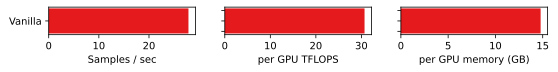

In [9]:
# Plot results
compare([bert_8_v1], "vanilla.pdf" if dump_fig_to_pdf else None)

## Setup epoi and xFormers
epoi stands for efficient PyTorch operator inventory, which includes a set of high efficient PyTorch modules. In this  benchmark, we will make use of these modules in HuggingFace Bert.

In addition, eopi uses modules from xFormers, so we also need to make sure it is available

In [10]:
def build_package(name, url):
    import importlib
    import os, sys
    if importlib.util.find_spec(name) is None:
        os.system(f"git clone {url} {name} || true")
        os.system(f"cd {name}; git submodule update --init --recursive")
        os.system(f"cd {name}; pip3 install -r requirements.txt || true")
        os.system(f'cd {name}; pip3 install -e ".[dev]"') 

build_package("xformers", "https://github.com/facebookresearch/xformers.git")
build_package("epoi", "https://github.com/comaniac/epoi.git")

### Replace Softmax

In [11]:
with open("transformers/v2.patch", "w") as f:
    f.write('''
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 11664f66c..a9bdbc556 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -51,6 +51,10 @@ from ...utils import (
 )
 from .configuration_bert import BertConfig

+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None

 logger = logging.get_logger(__name__)

@@ -344,7 +348,8 @@ class BertSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask

         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        assert xformers_softmax is not None
+        attention_probs = xformers_softmax(attention_scores)

         # This is actually dropping out entire tokens to attend to, which might
         # seem a bit unusual, but is taken from the original Transformer paper.
''')

!cd transformers; git apply v2.patch; rm v2.patch; git diff src/transformers/models/bert/modeling_bert.py

diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 11664f66c..a9bdbc556 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -51,6 +51,10 @@ from ...utils import (
 )
 from .configuration_bert import BertConfig
 
+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None
 
 logger = logging.get_logger(__name__)
 
@@ -344,7 +348,8 @@ class BertSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        assert xformers_softmax is not None
+        attention_probs = xformers_softmax(attention_scores)
 
         # This is actually dropping out entire tokens to attend to, which might
         # seem a bit unusual, but is taken fro

In [12]:
bert_8_v2 = hf_bert(Exp('+softmax', 'bert-large-uncased', 8, fp16=True, optim='adamw_apex_fused',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 8 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1
Total samples / second	: 28.1
Per GPU memory (GB)	: 15.0
Per GPU TFLOPs		: 30.9


Samples / sec: ['27.87', '28.05']
per GPU TFLOPS: ['30.69', '30.89']
per GPU memory (GB): ['14.78', '15.05']


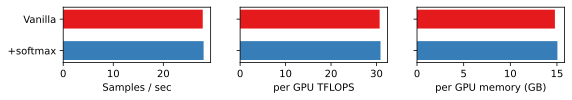

In [13]:
compare([bert_8_v1, bert_8_v2], "add_softmax.pdf" if dump_fig_to_pdf else None)

The speedup is not obvious in this benchmark, because we use Apex AMP that uses FP16 to compute softmax. On the other hand, xFormers's softmax uses FP32 to preserve the accuracy. From the following benchmark, you can see that xFormers (Comp-FP32) has similar latencies as PyTorch (Comp-FP16).

In [14]:
!python3 -m epoi.benchmark --only-run softmax

  Package       Version                    Commit SHA
------------  ------------  ----------------------------------------
    epoi        0.1.dev     7581ef3e0ea1146c58b2633ef30444552a1120e3
   torch      1.12.1+cu116                    N/A
transformers  4.24.0.dev0   12ce2941c7b67c0dedac0f0468b3ed854fa940ab
  xformers     0.0.14.dev   ba93c5012d00bd1b010514a7bc9bd938c1ad6149
  megatron        N/A                         N/A
   triton        2.0.0                        N/A
    apex          0.1                         N/A
[2022-10-21 18:54:09] INFO main: Skipped bias_gelu
[2022-10-21 18:54:09] INFO main: Skipped dropout_add_ln
[2022-10-21 18:54:09] INFO main: Skipped bert_attention
[2022-10-21 18:54:09] INFO main: Skipped gpt_attention
[2022-10-21 18:54:09] INFO main: Skipped qkv_self_attn
[2022-10-21 18:54:09] INFO main: Skipped layer_norm
[2022-10-21 18:54:09] INFO main: Selected softmax
[2022-10-21 18:54:09] INFO main: Running selected 1/7 cases
[2022-10-21 18:54:09] INFO main: [1

### Replace bias+GeLU
Note that this patch is on top of the previous patch, so has to be applied after applying the softmax patch.

In [15]:
with open("transformers/v3.patch", "w") as f:
    f.write('''
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index a9bdbc556..7ed14a7f2 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -438,11 +438,11 @@ class BertAttention(nn.Module):
 class BertIntermediate(nn.Module):
     def __init__(self, config):
         super().__init__()
-        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
-        if isinstance(config.hidden_act, str):
-            self.intermediate_act_fn = ACT2FN[config.hidden_act]
-        else:
-            self.intermediate_act_fn = config.hidden_act
+        self.dense = nn.Linear(config.hidden_size, config.intermediate_size, bias=True)
+        from epoi.ops.torchscript_ops import FusedBiasGELU
+        self.dense = nn.Linear(config.hidden_size, config.intermediate_size, bias=False)
+        assert config.hidden_act == "gelu"
+        self.intermediate_act_fn = FusedBiasGELU(config.intermediate_size, prev_weight=self.dense.weight)

     def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
         hidden_states = self.dense(hidden_states)
''')

!cd transformers; git apply v3.patch; rm v3.patch; git diff src/transformers/models/bert/modeling_bert.py

diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 11664f66c..7ed14a7f2 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -51,6 +51,10 @@ from ...utils import (
 )
 from .configuration_bert import BertConfig
 
+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None
 
 logger = logging.get_logger(__name__)
 
@@ -344,7 +348,8 @@ class BertSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        assert xformers_softmax is not None
+        attention_probs = xformers_softmax(attention_scores)
 
         # This is actually dropping out entire tokens to attend to, which might
         # seem a bit unusual, but is taken fro

In [16]:
bert_8_v3 = hf_bert(Exp('+bias_gelu', 'bert-large-uncased', 8, fp16=True, optim='adamw_apex_fused',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 8 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1
Total samples / second	: 27.6
Per GPU memory (GB)	: 13.9
Per GPU TFLOPs		: 30.4


Samples / sec: ['27.87', '28.05', '27.57']
per GPU TFLOPS: ['30.69', '30.89', '30.35']
per GPU memory (GB): ['14.78', '15.05', '13.87']


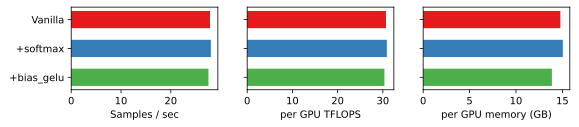

In [17]:
compare([bert_8_v1, bert_8_v2, bert_8_v3], "add_bias_gelu.pdf" if dump_fig_to_pdf else None)

We can see that this does not improve the throughput in bert-large, but it does useful in larger models. For example, we benchmark bias+gelu along with various model configurations:

In [18]:
!python3 -m epoi.benchmark --only-run bias_gelu

  Package       Version                    Commit SHA
------------  ------------  ----------------------------------------
    epoi        0.1.dev     7581ef3e0ea1146c58b2633ef30444552a1120e3
   torch      1.12.1+cu116                    N/A
transformers  4.24.0.dev0   12ce2941c7b67c0dedac0f0468b3ed854fa940ab
  xformers     0.0.14.dev   ba93c5012d00bd1b010514a7bc9bd938c1ad6149
  megatron        N/A                         N/A
   triton        2.0.0                        N/A
    apex          0.1                         N/A
[2022-10-21 18:55:15] INFO main: Selected bias_gelu
[2022-10-21 18:55:15] INFO main: Skipped dropout_add_ln
[2022-10-21 18:55:15] INFO main: Skipped bert_attention
[2022-10-21 18:55:15] INFO main: Skipped gpt_attention
[2022-10-21 18:55:15] INFO main: Skipped qkv_self_attn
[2022-10-21 18:55:15] INFO main: Skipped layer_norm
[2022-10-21 18:55:15] INFO main: Skipped softmax
[2022-10-21 18:55:15] INFO main: Running selected 1/7 cases
[2022-10-21 18:55:15] INFO main: [1

### Replace Dropout+Add+LayerNorm
Note that this patch is on top of the previous patch.

In [19]:
with open("transformers/v4.patch", "w") as f:
    f.write('''
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 7ed14a7f2..2c702fba6 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -454,13 +454,13 @@ class BertOutput(nn.Module):
     def __init__(self, config):
         super().__init__()
         self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
-        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
-        self.dropout = nn.Dropout(config.hidden_dropout_prob)
+        from epoi.ops.torchscript_ops import FusedDropoutAddLayerNorm
+        self.dropout_add_layernorm = FusedDropoutAddLayerNorm(config.hidden_size,
+            config.hidden_dropout_prob, eps=config.layer_norm_eps)

     def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
         hidden_states = self.dense(hidden_states)
-        hidden_states = self.dropout(hidden_states)
-        hidden_states = self.LayerNorm(hidden_states + input_tensor)
+        hidden_states = self.dropout_add_layernorm(hidden_states, input_tensor)
         return hidden_states


''')

!cd transformers; git apply v4.patch; rm v4.patch; git diff src/transformers/models/bert/modeling_bert.py

diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 11664f66c..2c702fba6 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -51,6 +51,10 @@ from ...utils import (
 )
 from .configuration_bert import BertConfig
 
+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None
 
 logger = logging.get_logger(__name__)
 
@@ -344,7 +348,8 @@ class BertSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        assert xformers_softmax is not None
+        attention_probs = xformers_softmax(attention_scores)
 
         # This is actually dropping out entire tokens to attend to, which might
         # seem a bit unusual, but is taken fro

In [20]:
bert_8_v4 = hf_bert(Exp('+dropout_add_ln', 'bert-large-uncased', 8, fp16=True, optim='adamw_apex_fused',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 8 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1
Total samples / second	: 28.3
Per GPU memory (GB)	: 13.9
Per GPU TFLOPs		: 31.1


Samples / sec: ['27.87', '28.05', '27.57', '28.27']
per GPU TFLOPS: ['30.69', '30.89', '30.35', '31.12']
per GPU memory (GB): ['14.78', '15.05', '13.87', '13.87']


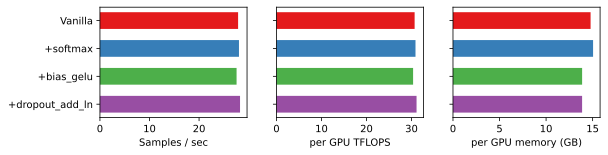

In [21]:
compare([bert_8_v1, bert_8_v2, bert_8_v3, bert_8_v4], "add_dropout_add_ln.pdf" if dump_fig_to_pdf else None)

Again this kernel is more benefitical for larger models:

In [22]:
!python3 -m epoi.benchmark --only-run dropout_add_ln

  Package       Version                    Commit SHA
------------  ------------  ----------------------------------------
    epoi        0.1.dev     7581ef3e0ea1146c58b2633ef30444552a1120e3
   torch      1.12.1+cu116                    N/A
transformers  4.24.0.dev0   12ce2941c7b67c0dedac0f0468b3ed854fa940ab
  xformers     0.0.14.dev   ba93c5012d00bd1b010514a7bc9bd938c1ad6149
  megatron        N/A                         N/A
   triton        2.0.0                        N/A
    apex          0.1                         N/A
[2022-10-21 18:56:49] INFO main: Skipped bias_gelu
[2022-10-21 18:56:49] INFO main: Selected dropout_add_ln
[2022-10-21 18:56:49] INFO main: Skipped bert_attention
[2022-10-21 18:56:49] INFO main: Skipped gpt_attention
[2022-10-21 18:56:49] INFO main: Skipped qkv_self_attn
[2022-10-21 18:56:49] INFO main: Skipped layer_norm
[2022-10-21 18:56:49] INFO main: Skipped softmax
[2022-10-21 18:56:49] INFO main: Running selected 1/7 cases
[2022-10-21 18:56:49] INFO main: [1

### Replace Attention Layer
1. Note that this patch is on top of the previous patch.
2. We replace BertSelfAttention with xFormers' FlashAttention implementation, which is memory efficient and could support a larger batch size. On the other hand, the current CUTLASS kernel for FlashAttntion doesn't support attention mask, so the result is actually incorrect. We will fix that in the future.

In [23]:
with open("transformers/v5.patch", "w") as f:
    f.write('''
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 7ed14a7f2..44d13b635 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -389,7 +389,8 @@ class BertSelfOutput(nn.Module):
 class BertAttention(nn.Module):
     def __init__(self, config, position_embedding_type=None):
         super().__init__()
-        self.self = BertSelfAttention(config, position_embedding_type=position_embedding_type)
+        from epoi.ops.xformers_attn import BertSelfAttention as xFormersBertSelfAttention
+        self.self = xFormersBertSelfAttention(config, position_embedding_type=position_embedding_type, attn_op_name="cutlass")
         self.output = BertSelfOutput(config)
         self.pruned_heads = set()


''')

!cd transformers; git apply v5.patch; rm v5.patch; git diff src/transformers/models/bert/modeling_bert.py

diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 11664f66c..0dcd777db 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -51,6 +51,10 @@ from ...utils import (
 )
 from .configuration_bert import BertConfig
 
+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None
 
 logger = logging.get_logger(__name__)
 
@@ -344,7 +348,8 @@ class BertSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        assert xformers_softmax is not None
+        attention_probs = xformers_softmax(attention_scores)
 
         # This is actually dropping out entire tokens to attend to, which might
         # seem a bit unusual, but is taken fro

In [24]:
bert_8_v5 = hf_bert(Exp('+flash_attn(bs8)', 'bert-large-uncased', 8, fp16=True, optim='adamw_apex_fused',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 8 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1
Total samples / second	: 31.4
Per GPU memory (GB)	: 9.6
Per GPU TFLOPs		: 34.5


In [25]:
bert_12_v5 = hf_bert(Exp('+flash_attn(bs12)', 'bert-large-uncased', 12, fp16=True, optim='adamw_apex_fused',
                     kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))

Running command export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 12 --fp16 True --bf16 False --optim adamw_apex_fused --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log.txt 2>&1
Total samples / second	: 35.1
Per GPU memory (GB)	: 12.0
Per GPU TFLOPs		: 38.7


Samples / sec: ['27.87', '28.05', '27.57', '28.27', '31.36', '35.15']
per GPU TFLOPS: ['30.69', '30.89', '30.35', '31.12', '34.53', '38.70']
per GPU memory (GB): ['14.78', '15.05', '13.87', '13.87', '9.58', '11.98']


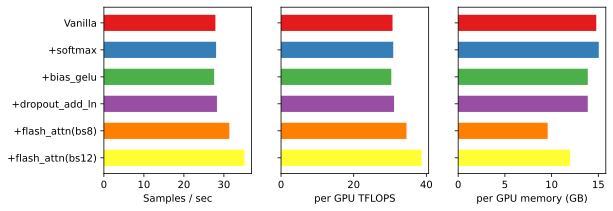

In [26]:
compare([bert_8_v1, bert_8_v2, bert_8_v3, bert_8_v4, bert_8_v5, bert_12_v5], "add_flash_attn.pdf" if dump_fig_to_pdf else None)